# 🧪 Exploratory Data Analysis (EDA) - Tomato Disease Dataset

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
from tensorflow.keras import layers
import cv2
import os
from eda_utils import plot_sample_images, plot_augmented_images

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

## Load Dataset

In [3]:
# Load image dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)
CLASS_NAMES=[name.replace('Tomato_', '').lstrip('_') for name in dataset.class_names]

Found 16011 files belonging to 10 classes.


## Sample Image Grid

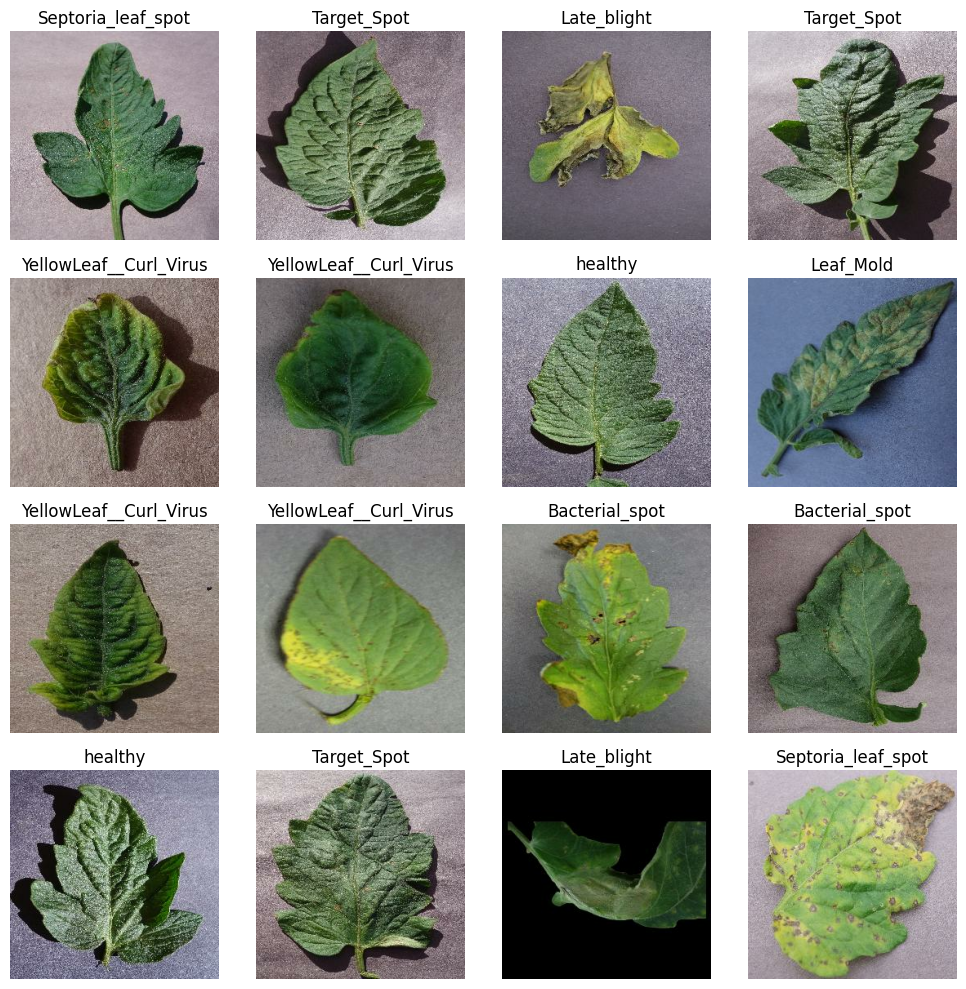

In [4]:
plot_sample_images(dataset,CLASS_NAMES)

## Class Distribution

Shows if your dataset is imbalanced (very important for multi-class classification).

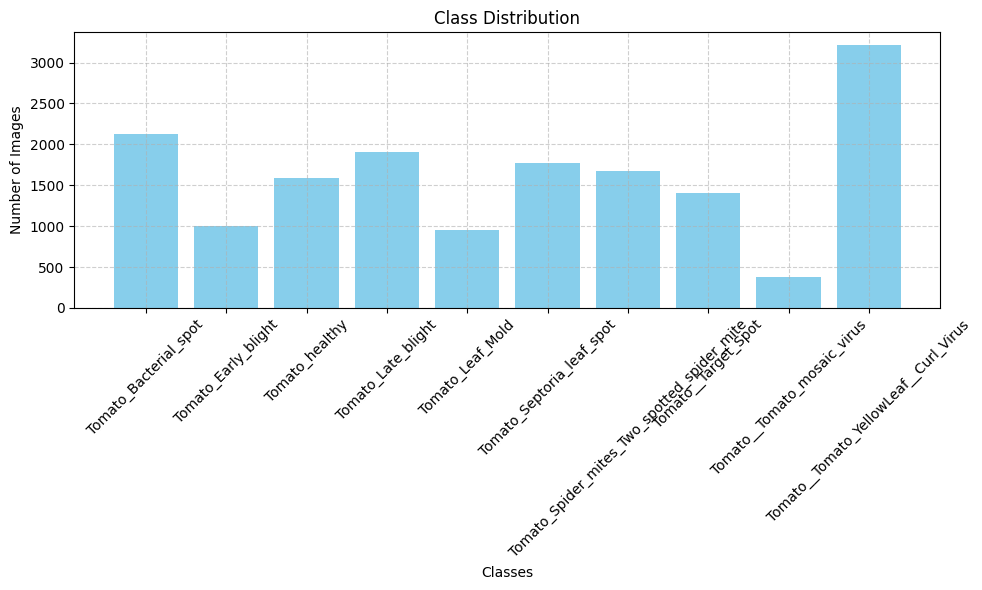

In [5]:
class_counts={}
for folder in os.listdir('PlantVillage'):
    path=os.path.join('PlantVillage',folder)
    class_counts[folder]=len(os.listdir(os.path.join('PlantVillage',folder)))

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Image Size Distribution

Sometimes datasets have inconsistent image sizes (if not resized already). You can visualize this to catch outliers.

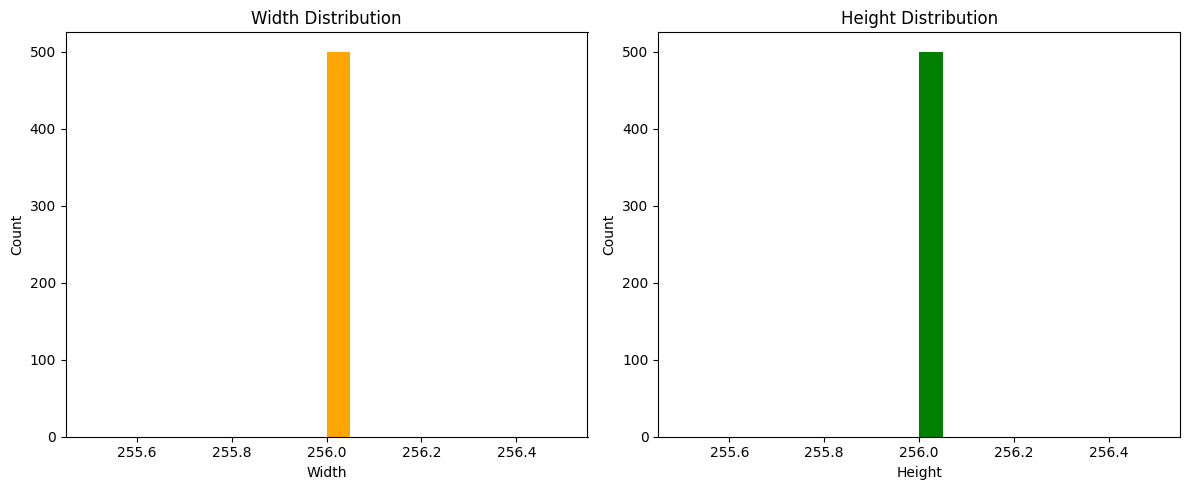

In [6]:
img_shapes = []

for cls in os.listdir('PlantVillage'):
    cls_path = os.path.join('PlantVillage', cls)
    for img_name in os.listdir(cls_path)[:50]:  # limit to 50 per class to save time
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            img_shapes.append((w, h))

widths, heights = zip(*img_shapes)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='orange')
plt.title("Width Distribution")
plt.xlabel("Width")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color='green')
plt.title("Height Distribution")
plt.xlabel("Height")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## Pixel Intensity Distribution (for grayscale or quality check)

quality check if you notice noise or weird brightness issues.

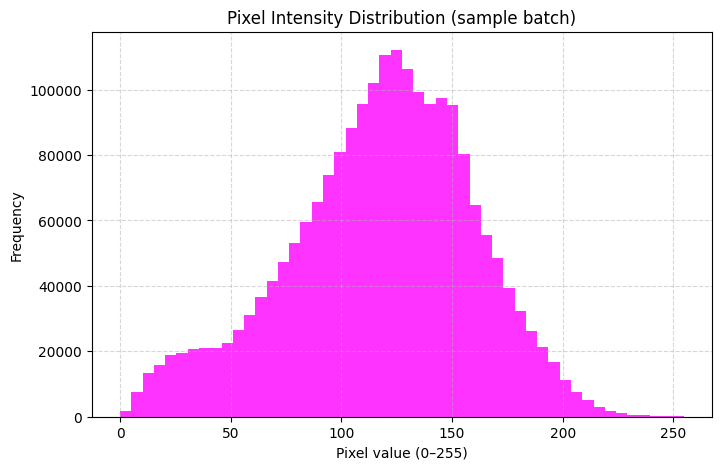

In [7]:
images, _ = next(iter(dataset))

# Convert to grayscale: shape becomes [batch_size, H, W, 1]
gray_images = tf.image.rgb_to_grayscale(images)

# Flatten all pixels in that batch
pixels = tf.reshape(gray_images, [-1])

plt.figure(figsize=(8, 5))
plt.hist(pixels.numpy(), bins=50, alpha=0.8,color='magenta')
plt.title("Pixel Intensity Distribution (sample batch)")
plt.xlabel("Pixel value (0–255)")
plt.ylabel("Frequency")
plt.grid(linestyle="--", alpha=0.5)
plt.show()

## t-SNE plot of image embeddings

This shows how similar images cluster in high-dimensional space. It show dataset separability.
t-SNE (t-Distributed Stochastic Neighbor Embedding) reduces embeddings to 2D for plotting.

- we see how distinct or overlapping your classes are.
- It gives insight into which classes the model might confuse.

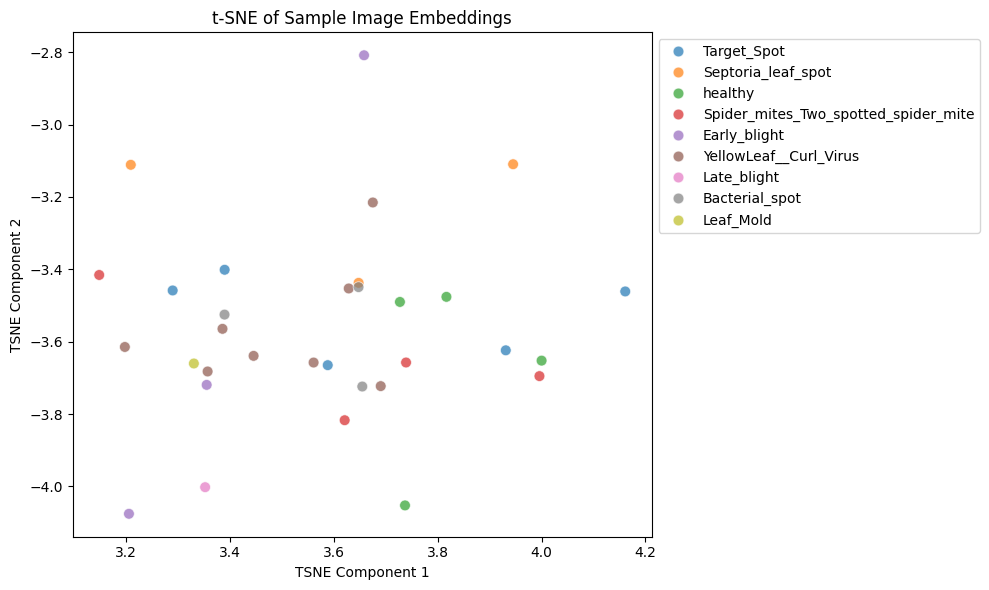

In [8]:
# Get one batch from dataset
images, labels = next(iter(dataset))

# Normalize and flatten each image (e.g., 256x256x3 → 196608)
flat_images = tf.reshape(images / 255.0, (images.shape[0], -1)).numpy()

# Reduce to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(flat_images)

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=[CLASS_NAMES[label] for label in labels.numpy()],
    palette="tab10",
    alpha=0.7,
    s=60
)
plt.title("t-SNE of Sample Image Embeddings")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend(loc="best", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Visualize original vs augmented images

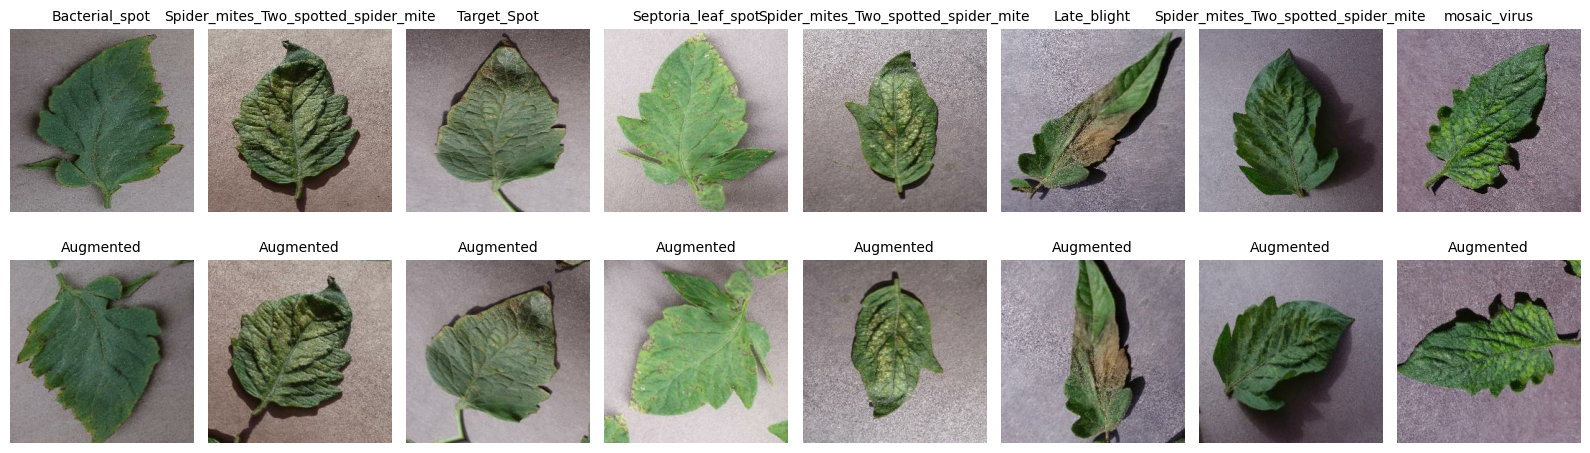

In [9]:
augment = tf.keras.Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.2),
])
plot_augmented_images(dataset, augment, CLASS_NAMES)